In [1]:
import torch
import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid
import sys
import requests
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [2]:
# https://github.com/facebookresearch/detr

In [3]:
# device = torch.device('cpu')
device = torch.device(0)

In [4]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [5]:
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True).to(device)

Using cache found in /home/alan/.cache/torch/hub/facebookresearch_detr_main
/home/alan/miniconda3/envs/mytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alan/miniconda3/envs/mytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
dt = 20240304

In [7]:
class ImageSet(Dataset):
    def __init__(self):
        super().__init__()
        self.img_files = sorted(glob.glob(f'images/{dt}_*.jpg'))
        self.transform =  T.Compose([
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, i):
        img_file = self.img_files[i]
        img = Image.open(img_file)
        Z = self.transform(img)  #[:, ::2, ::2]
        return Z, img_file

In [8]:
imset = ImageSet()
loader = DataLoader(imset, batch_size=1, shuffle=False)

In [9]:
to_pil = T.Compose([
    T.Lambda(lambda x: (x+1)/2),
    T.ToPILImage()
])

In [10]:
fname = f'results/detr_results_{dt}.txt'
with open(fname, 'w') as fout:
    fout.write('filename;score;bbox\n')

images/20240304_105405415831.jpg 0.9543282389640808 [0.4024599492549896, 0.4071679413318634, 0.0587049201130867, 0.13600653409957886]
images/20240304_105405415831.jpg 0.7678125500679016 [0.5169411897659302, 0.5506518483161926, 0.07532311230897903, 0.15849418938159943]


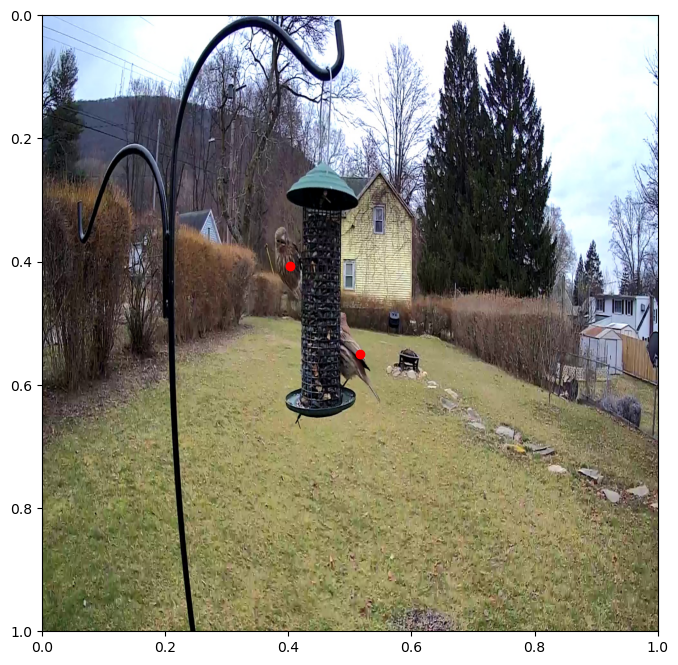

	images/20240304_105702917077.jpg	

In [ ]:
for (Z, img_file) in loader:
    sys.stdout.write(f'\r\t{img_file[0]}\t')
    Z = Z.to(device)
    results = model(Z)
    
    probs = results['pred_logits'].softmax(-1)
    idx = probs.argmax(-1)

    n_birds = (idx == 16).sum().item()
    
    if n_birds > 0:

        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(15, 8))
        im = to_pil(make_grid(Z, nrow=1))
        ax.imshow(im, extent=(0, 1, 1, 0))
        for i in range(n_birds):
            score = probs[idx==16][i][16].item()
            bbox = results['pred_boxes'][idx==16][i].tolist()
            ax.plot(
                results['pred_boxes'][idx==16][i][0].item(),
                results['pred_boxes'][idx==16][i][1].item(),
                'ro-'
            )
            print(img_file[0], score, bbox)

            with open(fname, 'a') as fout:
                fout.write(f'{img_file[0]};{score};{bbox}\n')

        plt.show()